# DM - Classification [TASK 3]

Construction of classification model able to discriminate a bot by available values.

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from wittgenstein import RIPPER
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from scikeras.wrappers import KerasClassifier

from utils import fetch_preprocessed_dataset

import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in classification phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  11508 non-null  int64  
 1   statuses_count              11508 non-null  int64  
 2   bot                         11508 non-null  int64  
 3   tweets_num                  11508 non-null  int64  
 4   tweets_2020_num             11508 non-null  int64  
 5   likes_num                   11508 non-null  float64
 6   comments_num                11508 non-null  float64
 7   ratio_likes_x_tweets        11508 non-null  float64
 8   entropy                     11508 non-null  float64
 9   texts_mean_length           11508 non-null  float64
 10  texts_special_chars_length  11508 non-null  float64
 11  mean_pub_range              11508 non-null  float64
 12  mean_texts_similarity       11508 non-null  float64
dtypes: float64(8), int64(5)
memory 

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

lg.info(f"train_set: {train_set.shape}")
lg.info(f"train_label: {train_label.shape}")
lg.info(f"test_set: {test_set.shape}")
lg.info(f"test_label: {test_label.shape}")

2023-01-06 06:18:14,665 - root - INFO - train_set: (9206, 12)
2023-01-06 06:18:14,665 - root - INFO - train_label: (9206,)
2023-01-06 06:18:14,666 - root - INFO - test_set: (2302, 12)
2023-01-06 06:18:14,666 - root - INFO - test_label: (2302,)


## Classification models

Dictionary used to collect models predictions in order to compare them in the end of the analysis.

In [5]:
predictions = {}

Scaler used to standardize train and test set. Scaled data are used only in some of following models.

In [6]:
scaler = StandardScaler()
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

Function able to provide a grid search for each of the following model. This grid search uses cross validation method to evaluate the best model.

In [7]:
def gridsearch(train_set, train_label, model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4)
    return gs.fit(train_set, train_label)

Function able to plot train and test metrics.

In [8]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

Plot realated to train and test confusion matrixes.

In [9]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

### Decision tree

Decision tree grid search.

In [10]:
params = dict(
    max_depth=[5, 10, 20, 30, 40, 50],
    min_samples_leaf=[1, 2, 3, 4, 5]
)
dt = DecisionTreeClassifier(criterion='gini', splitter='best')
scores = gridsearch(train_set, train_label, dt, params)

scores

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

Best parameters selected by previous grid search.

In [11]:
scores.best_params_

{'max_depth': 10, 'min_samples_leaf': 3}

Decision tree construction by best parameters selected and fitting.

In [12]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', **scores.best_params_)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3)

Decision tree prediction.

In [13]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

predictions["Decision tree"] = (train_pred_dt, test_pred_dt)

Decision tree metrics plot.

In [14]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.97      0.74      0.84      4313
         bot       0.81      0.98      0.89      4893

    accuracy                           0.87      9206
   macro avg       0.89      0.86      0.86      9206
weighted avg       0.88      0.87      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.91      0.68      0.78      1079
         bot       0.77      0.94      0.85      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.81      2302
weighted avg       0.84      0.82      0.81      2302



Decision tree confusion matrices plot for train and test set.

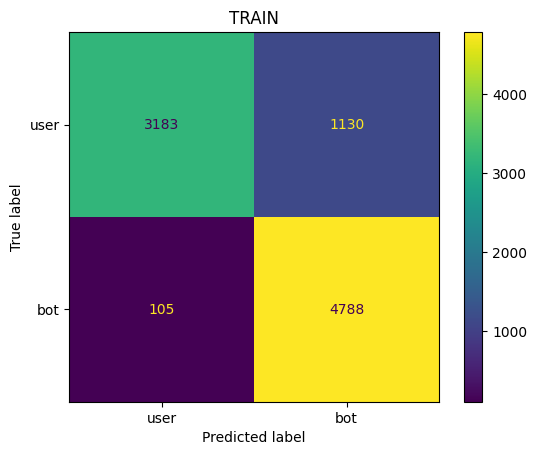

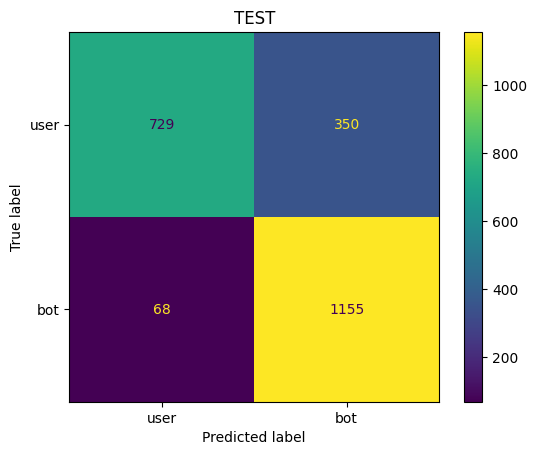

In [15]:
plot_cms(train_pred_dt, test_pred_dt)

### K-nearest neighbors (KNN)

KNN grid search.

In [16]:
params = dict(n_neighbors=list(range(1, int(math.sqrt(train_set.shape[0])))))

knn = KNeighborsClassifier()
scores = gridsearch(train_set_scaled, train_label, knn, params)

scores

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

Best parameters selected by previous grid search.

In [17]:
scores.best_params_

{'n_neighbors': 21}

KNN model creation by best parameters selected and fitting.

In [18]:
knn = KNeighborsClassifier(**scores.best_params_)
knn = knn.fit(train_set_scaled, train_label)

KNN prediction for train and test datasets.

In [19]:
train_pred_knn = knn.predict(train_set_scaled)
test_pred_knn = knn.predict(test_set_scaled)

predictions["KNN"] = (train_pred_knn, test_pred_knn)

Printing of KNN train and test metrics.

In [20]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.91      0.59      0.72      4313
         bot       0.72      0.95      0.82      4893

    accuracy                           0.78      9206
   macro avg       0.82      0.77      0.77      9206
weighted avg       0.81      0.78      0.77      9206

TEST
              precision    recall  f1-score   support

        user       0.87      0.58      0.69      1079
         bot       0.71      0.92      0.80      1223

    accuracy                           0.76      2302
   macro avg       0.79      0.75      0.75      2302
weighted avg       0.78      0.76      0.75      2302



NKK train and test confusion matrices.

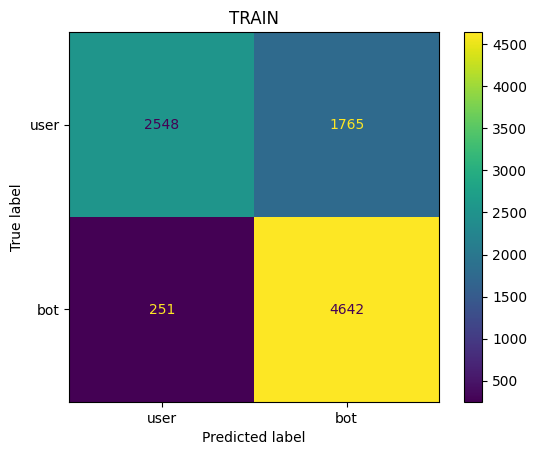

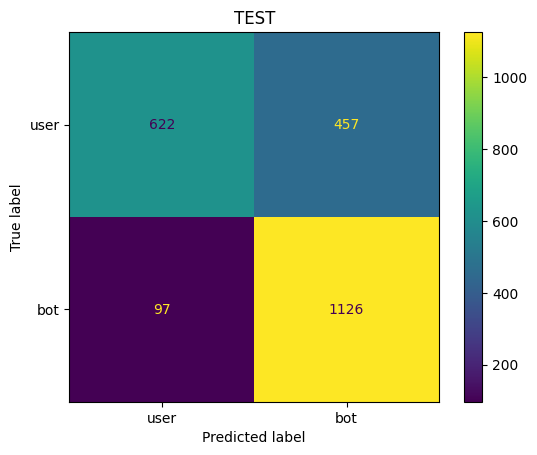

In [21]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

Preparation of dedicated `train_set` to solve numeric problem.

In [22]:
train_set_rb = train_set.copy()

# RIPPER doesn't work with entropy rounded more than 4
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

Grid search of rule-based approach,

In [ ]:
params = dict(
    k=[1, 2, 3],
    prune_size=[0.2, 0.33, 0.5]
)

rb = RIPPER(random_state=0)
scores = gridsearch(train_set_rb, train_label, rb, params)

scores

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed 

Previous selected best params.

In [ ]:
scores.best_params_

Ripper model creation with best parameters selected and fitting.

In [ ]:
rb = RIPPER(random_state=0, **scores.best_params_)
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm. This is a unique long rule written in *disjunctive normal form* (disjunction of conjunction) to assign to the output the label `bot` in case of `true` result.

In [ ]:
rb.out_model()

Prediction of rule-based algorithm for training and test set.

In [ ]:
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

predictions["Rule-based"] = (train_pred_rb, test_pred_rb)

Printing of training and test metrics.

In [ ]:
report_scores(train_pred_rb, test_pred_rb)

Train and test confusion matrix of ripper.

In [ ]:
plot_cms(train_pred_rb, test_pred_rb)

### Naive Bayes

Construction of naive bayes model and fitting.

In [ ]:
nb = GaussianNB()
nb.fit(train_set, train_label)

Naive bayes model predictions for training and test set.

In [ ]:
train_pred_nb = nb.predict(train_set)
test_pred_nb = nb.predict(test_set)

predictions["Naive Bayes"] = (train_pred_nb, test_pred_nb)

Train and test metrics naive bayes model plot.

In [ ]:
report_scores(train_pred_nb, test_pred_rb)

Naive bayes train and test confusion matrices.

In [ ]:
plot_cms(train_pred_nb, test_pred_rb)

### Ensemble methods

Here there are two ensemble methods used: boost and random forest.

#### AdaBoost

AdaBoost grid search.

In [ ]:
params = dict(
    n_estimators=list(range(10, 201, 10)),
    learning_rate=[0.1, 0.3, 0.05, 0.01]
)

boost = AdaBoostClassifier()
scores = gridsearch(train_set, train_label, boost, params)

scores

AdaBoost best parameters selected by previous grid search.

In [ ]:
scores.best_params_

AdaBoost model construction useing best parameters selected and then model training.

In [ ]:
boost = AdaBoostClassifier(**scores.best_params_)
boost.fit(train_set, train_label)

AdaBoost prediction of training and test set.

In [ ]:
train_pred_boost = boost.predict(train_set)
test_pred_boost = boost.predict(test_set)

predictions["AdaBoost"] = (train_pred_boost, test_pred_boost)

Print of AdaBoost train and test metrics.

In [ ]:
report_scores(train_pred_boost, test_pred_boost)

AdaBoost training and test confusion matrices.

In [ ]:
plot_cms(train_pred_boost, test_pred_boost)

#### Random forest

Grid search of random forest.

In [ ]:
params = dict(n_estimators=list(range(10, 201, 10)))

rf = RandomForestClassifier()
scores = gridsearch(train_set, train_label, rf, params)

scores

Best parameters selected by previous grid search.

In [ ]:
scores.best_params_

Random forest model creation by best parameters selected.

In [ ]:
rf = RandomForestClassifier(**scores.best_params_)
rf.fit(train_set, train_label)

Random forest training and test predictions.

In [ ]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

predictions["Random forest"] = (train_pred_rf, test_pred_rf)

Print of training and test metrics.

In [ ]:
report_scores(train_pred_rf, test_pred_rf)

Plots of train and test confusion matrices.

In [ ]:
plot_cms(train_pred_rf, test_pred_rf)

### Support Vector Machine (SVM)

SVM grid search.

In [ ]:
params = dict(
    kernel=['rbf', 'sigmoid'],
    C=[1, 2, 5]
)

svm = SVC()
scores = gridsearch(train_set_scaled, train_label, svm, params)

scores

Best parameters selected by SVM grid search.

In [ ]:
scores.best_params_

SVM for classification model construction with best parameters selected.

In [ ]:
svm = SVC(**scores.best_params_)
svm.fit(train_set_scaled, train_label)

SVM training an test predictions.

In [ ]:
train_pred_svm = svm.predict(train_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)

predictions["SVM"] = (train_pred_svm, test_pred_svm)

Print of training and test SVM metrics.

In [ ]:
report_scores(train_pred_svm, test_pred_svm)

SVM training and test confusion metrices.

In [ ]:
plot_cms(train_pred_svm, test_pred_svm)

### Neural network

Dataset preparation by reshaping training and test set and labels.

In [ ]:
x_train_nn = np.reshape(train_set_scaled, (-1, 1, train_set.shape[1]))
x_test_nn = np.reshape(test_set_scaled, (-1, 1, test_set.shape[1]))
y_train_nn = np.asarray(train_label).reshape((-1,1))
y_test_nn = np.asarray(test_label).reshape((-1,1))

Definition of function able to construct a neural network.

In [ ]:
def create_nn(hidden_units, hidden_activation):
    nn = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(1, train_set.shape[1])),
            keras.layers.Dense(hidden_units, activation=hidden_activation),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    nn.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])

    return nn

Neural network grid search.

In [ ]:
params = dict(
    model__hidden_units=[32, 64, 128, 516, 1024, 2048],
    model__hidden_activation=['sigmoid', 'relu', 'tanh']
)

nn = KerasClassifier(model=create_nn, epochs = 100, batch_size = 516)
scores = gridsearch(x_train_nn, y_train_nn, nn, params)

scores

Best parameters selected by previous grid search.

In [ ]:
scores.best_params_

Neural network model creation with best parameters and fitting.

In [ ]:
best_params = {k.replace('model__', ''): v for k, v in scores.best_params_.items()}

nn = create_nn(**best_params)
nn.fit(x_train_nn, y_train_nn, epochs = 100, batch_size = 516)

Neural network predictions for training and test set.

In [ ]:
train_pred_nn = (nn.predict(x_train_nn) > 0.5).astype("int32")
test_pred_nn = (nn.predict(x_test_nn) > 0.5).astype("int32")

predictions["Neural network"] = (train_pred_nn, test_pred_nn)

Plot of training and test metrics.

In [ ]:
report_scores(train_pred_nn, test_pred_nn)

Plots of training and test confusion matrices.

In [ ]:
plot_cms(train_pred_nn, test_pred_nn)

## Model comparisons

Function able to abstract the creation of plot of ROC curve that shows comparisons among different models.

In [ ]:
def plot_roc(roc_type="test"):
    plt.figure(0).clf()
    is_test = roc_type == "test"
    index = 1 if is_test else 0

    for key, value in predictions.items():
        pred = value[index]
        label = test_label if is_test else train_label
        fpr, tpr, _ = metrics.roc_curve(label, pred)
        roc_auc = metrics.roc_auc_score(label, pred)
        plt.plot(fpr, tpr, label=f"{key}, roc_auc = {round(roc_auc, 2)}")
        plt.title("Test" if is_test else "Train")

    plt.legend(loc=0)

Comparisons among models with training set.

In [ ]:
plot_roc("train")

Comparisons among models with test set.

In [ ]:
plot_roc("test")